In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error,mean_squared_error
from sklearn import metrics

### dict_keys(['S&P', 'NYA', 'DJI', 'RUT', 'NASDAQ'])

# For S&P data 

## For 60 Days

In [3]:
DATADIR = "/content/"
TRAIN_TEST_CUTOFF = '2016-04-21'
TRAIN_VALID_RATIO = 0.75

# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
# to implement F1 score for validation in a batch
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1macro(y_true, y_pred):
    f_pos = f1_m(y_true, y_pred)
    # negative version of the data and prediction
    f_neg = f1_m(1-y_true, 1-K.clip(y_pred,0,1))
    return (f_pos + f_neg)/2

def cnnpred_2d(seq_len=60, n_features=82, n_filters=(8,8,8), droprate=0.1):
    "2D-CNNpred model according to the paper"
    model = Sequential([
        Input(shape=(seq_len, n_features, 1)),
        Conv2D(n_filters[0], kernel_size=(1, n_features), activation="relu"),
        Conv2D(n_filters[1], kernel_size=(3,1), activation="relu"),
        MaxPool2D(pool_size=(2,1)),
        Conv2D(n_filters[2], kernel_size=(3,1), activation="relu"),
        MaxPool2D(pool_size=(2,1)),
        Flatten(),
        #Dropout(droprate),
        Dense(1, activation="sigmoid")
    ])
    return model

def datagen(data, seq_len, batch_size, targetcol, kind,key):
    "As a generator to produce samples for Keras model"
    batch = []
    while True:
        # Pick one dataframe from the pool
        #key = random.choice(list(data.keys()))
        df = data[key]
        input_cols = [c for c in df.columns if c != targetcol]
        index = df.index[df.index < TRAIN_TEST_CUTOFF]
        split = int(len(index) * TRAIN_VALID_RATIO)
        assert split > seq_len, "Training data too small for sequence length {}".format(seq_len)
        if kind == 'train':
            index = index[:split]   # range for the training set
        elif kind == 'valid':
            index = index[split:]   # range for the validation set
        else:
            raise NotImplementedError
        # Pick one position, then clip a sequence length
        while True:
            t = random.choice(index)     # pick one time step
            n = (df.index == t).argmax() # find its position in the dataframe
            if n-seq_len+1 < 0:
                continue # this sample is not enough for one sequence length
            frame = df.iloc[n-seq_len+1:n+1]
            batch.append([frame[input_cols].values, df.loc[t, targetcol]])
            break
        # if we get enough for a batch, dispatch
        if len(batch) == batch_size:
            X, y = zip(*batch)
            X, y = np.expand_dims(np.array(X), 3), np.array(y)
            yield X, y
            batch = []

def testgen(data, seq_len, targetcol,key):
    "Return array of all test samples"
    batch = []
    df = data[key]
    #for key, df in data.items():
    input_cols = [c for c in df.columns if c != targetcol]
    # find the start of test sample
    t = df.index[df.index >= TRAIN_TEST_CUTOFF][0]
    n = (df.index == t).argmax()
    # extract sample using a sliding window
    for i in range(n+1, len(df)+1):
        frame = df.iloc[i-seq_len:i]
        batch.append([frame[input_cols].values, frame[targetcol][-1]])
    X, y = zip(*batch)
    return np.expand_dims(np.array(X),3), np.array(y)

# Read data into pandas DataFrames
data = {}
for filename in os.listdir('/content/'):
    if not filename.lower().endswith(".csv"):
        continue # read only the CSV files
    filepath = os.path.join('/content/', filename)
    X = pd.read_csv(filepath, index_col="Date", parse_dates=True)
    # basic preprocessing: get the name, the classification
    # Save the target variable as a column in dataframe for easier dropna()
    name = X["Name"][0]
    del X["Name"]
    cols = X.columns
    X["Target"] = (X["Close"].pct_change().shift(-1) > 0).astype(int)
    X.dropna(inplace=True)
    # Fit the standard scaler using the training dataset
    index = X.index[X.index < TRAIN_TEST_CUTOFF]
    index = index[:int(len(index) * TRAIN_VALID_RATIO)]
    scaler = StandardScaler().fit(X.loc[index, cols])
    # Save scale transformed dataframe
    X[cols] = scaler.transform(X[cols])
    data[name] = X

seq_len = 60
batch_size = 128
n_epochs = 4
n_features = 82

# Define AUC
Aucroc = tf.keras.metrics.AUC(curve="ROC")
# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'S&P'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'S&P'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'S&P')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 1, 8)          664       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 1, 8)          200       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 1, 8)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 1, 8)          200       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 1, 8)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 104)               0

In [4]:
history.history.keys()

dict_keys(['loss', 'acc', 'auc', 'f1macro', 'val_loss', 'val_acc', 'val_auc', 'val_f1macro'])

In [5]:
def plot_loss(train_loss,val_loss):
  loss_train = history.history[train_loss]
  loss_val = history.history[val_loss]
  plt.plot(loss_train, 'g', label='Training Loss')
  plt.plot(loss_val, 'b', label='validation Loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [6]:
def plot_accuracy(acc_train,acc_val):
  acc_train = history.history[acc_train]
  acc_val = history.history[acc_val]
  plt.plot(acc_train, 'g', label='Training Accuracy')
  plt.plot(acc_val, 'b', label='validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [7]:
def plot_f1macro(f1_train,f1_val):
  f1_train = history.history[f1_train]
  f1_val = history.history[f1_val]
  plt.plot(f1_train, 'g', label='Training F1macro')
  plt.plot(f1_val, 'b', label='validation F1macro')
  plt.title('Training and Validation F1macro')
  plt.xlabel('Epochs')
  plt.ylabel('F1macro')
  plt.legend()
  plt.show()

In [8]:
def plot_Aucroc(auc_train,auc_val):
  aucroc_train = history.history[auc_train]
  aucroc_val = history.history[auc_val]
  plt.plot(aucroc_train, 'g', label='Training AucRoc')
  plt.plot(aucroc_val, 'b', label='validation AucRoc')
  plt.title('Training and Validation AucRoc')
  plt.xlabel('Epochs')
  plt.ylabel('AUC')
  plt.legend()
  plt.show()

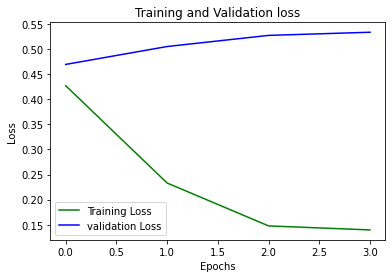

In [9]:
plot_loss('loss','val_loss')

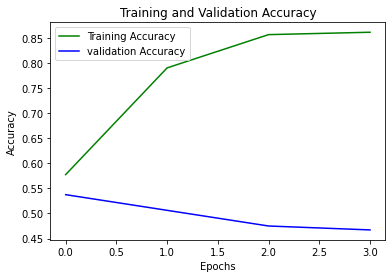

In [10]:
plot_accuracy('acc','val_acc')

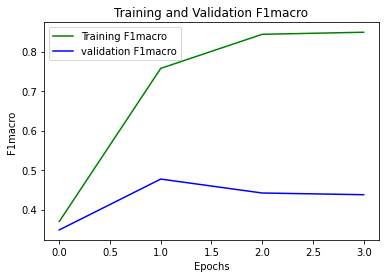

In [11]:
plot_f1macro('f1macro','val_f1macro')

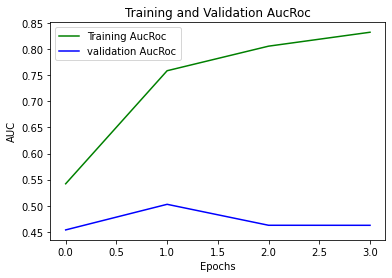

In [12]:
plot_Aucroc('auc','val_auc')

## For 30 Days

In [13]:
# for 30 days
seq_len = 30
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'S&P'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'S&P'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'S&P')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 1, 8)          664       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 1, 8)          200       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 1, 8)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 1, 8)          200       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 1, 8)          0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 48)               

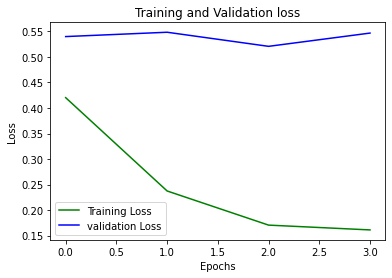

In [14]:
plot_loss('loss','val_loss')

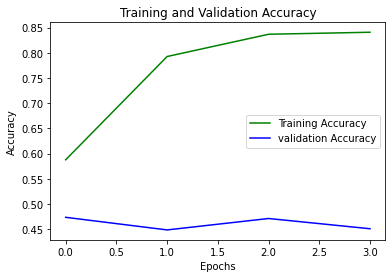

In [15]:
plot_accuracy('acc','val_acc')

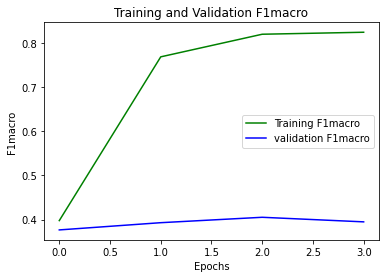

In [16]:
plot_f1macro('f1macro','val_f1macro')

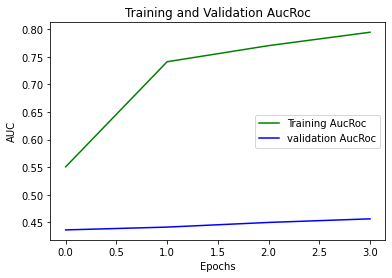

In [17]:
plot_Aucroc('auc','val_auc')

## For 20 Days

In [18]:
# for 20 days
seq_len = 20
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'S&P'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'S&P'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'S&P')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 20, 1, 8)          664       
                                                                 
 conv2d_7 (Conv2D)           (None, 18, 1, 8)          200       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 9, 1, 8)          0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 1, 8)           200       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 1, 8)          0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 24)               

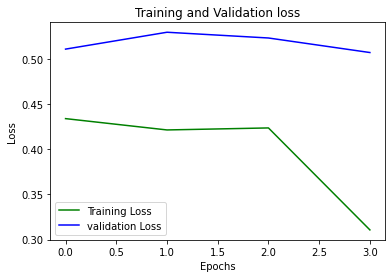

In [19]:
plot_loss('loss','val_loss')

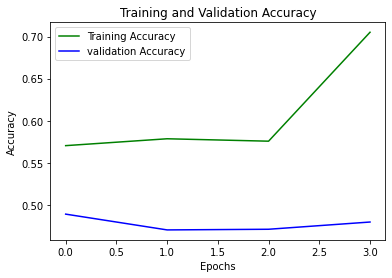

In [20]:
plot_accuracy('acc','val_acc')

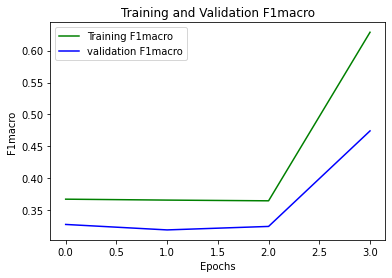

In [21]:
plot_f1macro('f1macro','val_f1macro')

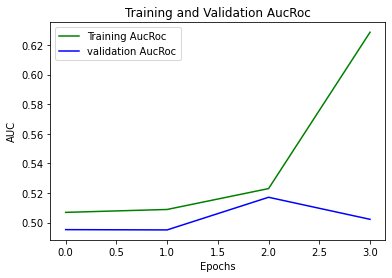

In [22]:
plot_Aucroc('auc','val_auc')

## For 10 Days

In [23]:
# for 10 days
seq_len = 10
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'S&P'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'S&P'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'S&P')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 10, 1, 8)          664       
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 1, 8)           200       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 1, 8)          0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 2, 1, 8)           200       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 1, 1, 8)          0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 8)                

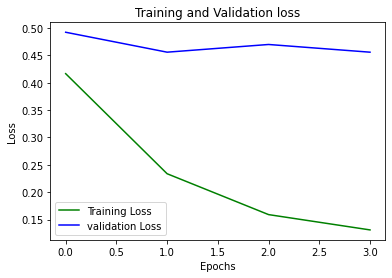

In [24]:
plot_loss('loss','val_loss')

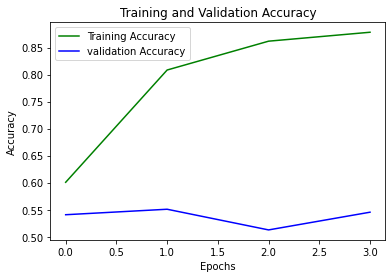

In [25]:
plot_accuracy('acc','val_acc')

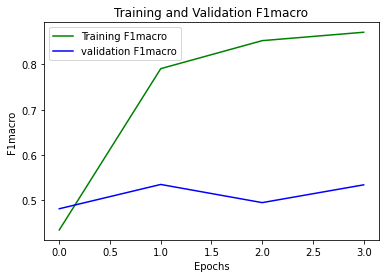

In [26]:
plot_f1macro('f1macro','val_f1macro')

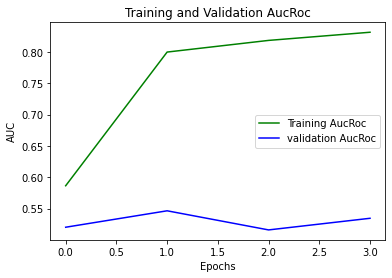

In [27]:
plot_Aucroc('auc','val_auc')

# For NYA

## For 60 Days

In [28]:
# For 60 Days
seq_len = 60
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'NYA'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'NYA'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'NYA')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 60, 1, 8)          664       
                                                                 
 conv2d_13 (Conv2D)          (None, 58, 1, 8)          200       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 29, 1, 8)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 27, 1, 8)          200       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 13, 1, 8)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 104)              

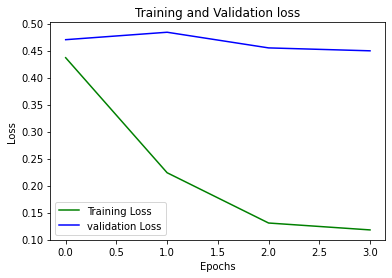

In [29]:
plot_loss('loss','val_loss')

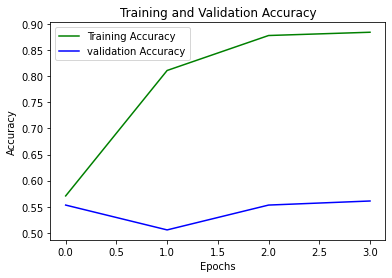

In [30]:
plot_accuracy('acc','val_acc')

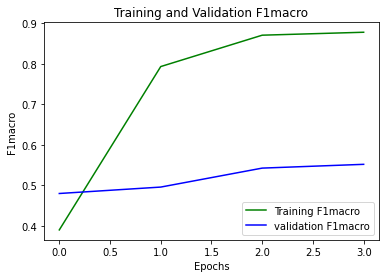

In [31]:
plot_f1macro('f1macro','val_f1macro')

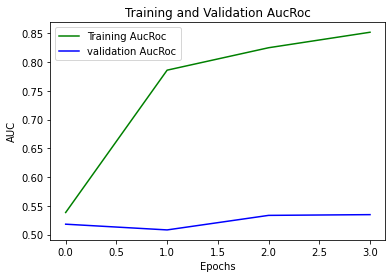

In [32]:
plot_Aucroc('auc','val_auc')

## For 30 Days

In [33]:
# For 30 Days
seq_len = 30
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'NYA'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'NYA'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'NYA')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 1, 8)          664       
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 1, 8)          200       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 1, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 1, 8)          200       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 1, 8)          0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 48)               

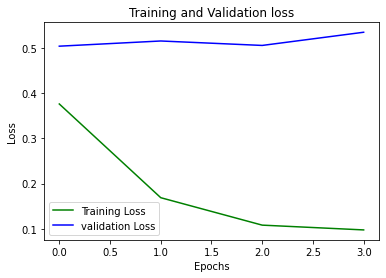

In [34]:
plot_loss('loss','val_loss')

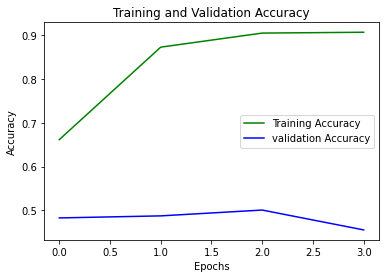

In [35]:
plot_accuracy('acc','val_acc')

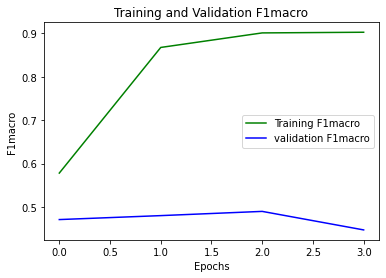

In [36]:
plot_f1macro('f1macro','val_f1macro')

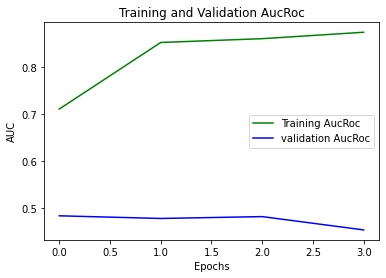

In [37]:
plot_Aucroc('auc','val_auc')

## For 20 Days

In [38]:
# For 20 Days
seq_len = 20
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'NYA'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'NYA'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'NYA')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 20, 1, 8)          664       
                                                                 
 conv2d_19 (Conv2D)          (None, 18, 1, 8)          200       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 9, 1, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 7, 1, 8)           200       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 3, 1, 8)          0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 24)               

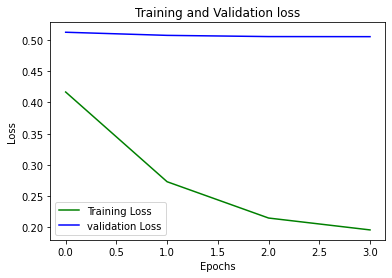

In [39]:
plot_loss('loss','val_loss')

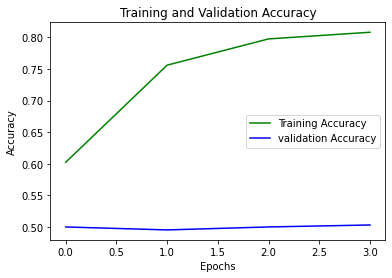

In [40]:
plot_accuracy('acc','val_acc')

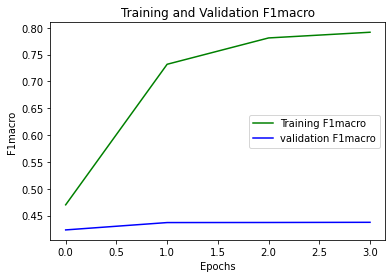

In [41]:
plot_f1macro('f1macro','val_f1macro')

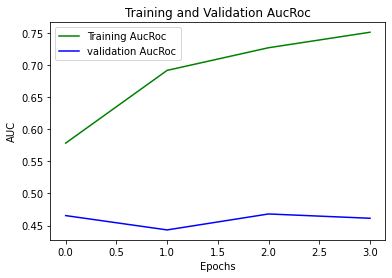

In [42]:
plot_Aucroc('auc','val_auc')

## For 10 Days

In [43]:
# For 10 Days
seq_len = 10
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'NYA'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'NYA'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'NYA')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 10, 1, 8)          664       
                                                                 
 conv2d_22 (Conv2D)          (None, 8, 1, 8)           200       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 4, 1, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 2, 1, 8)           200       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 1, 1, 8)          0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 8)                

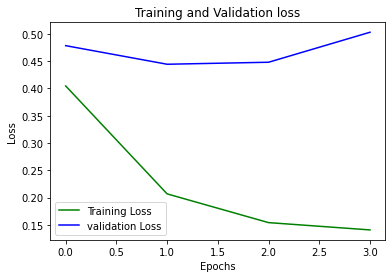

In [44]:
plot_loss('loss','val_loss')

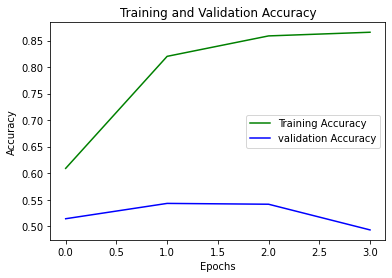

In [45]:
plot_accuracy('acc','val_acc')

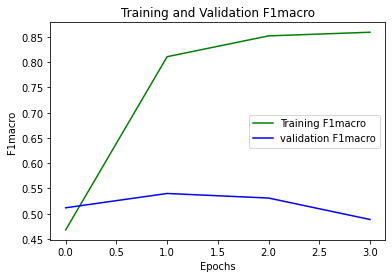

In [46]:
plot_f1macro('f1macro','val_f1macro')

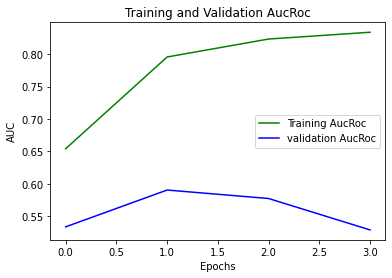

In [47]:
plot_Aucroc('auc','val_auc')

# For DJI

## For 60 Days

In [48]:
# For 60 Days
seq_len = 60
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'DJI'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'DJI'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'DJI')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 60, 1, 8)          664       
                                                                 
 conv2d_25 (Conv2D)          (None, 58, 1, 8)          200       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 29, 1, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 27, 1, 8)          200       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 13, 1, 8)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 104)              

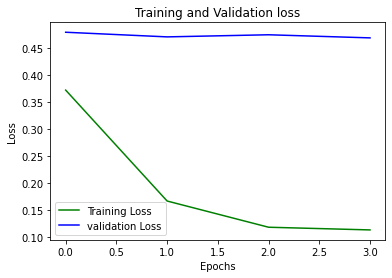

In [49]:
plot_loss('loss','val_loss')

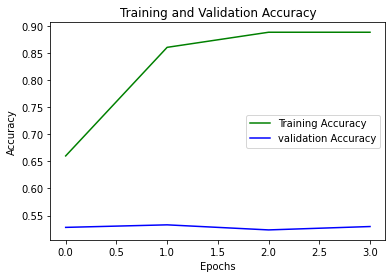

In [50]:
plot_accuracy('acc','val_acc')

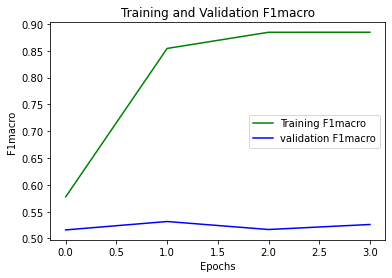

In [51]:
plot_f1macro('f1macro','val_f1macro')

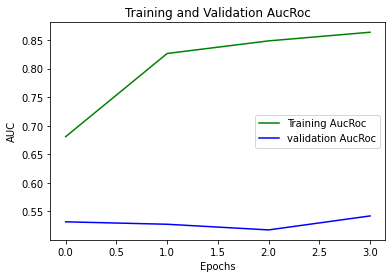

In [52]:
plot_Aucroc('auc','val_auc')

## For 30 Days

In [53]:
# For 30 Days
seq_len = 30
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'DJI'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'DJI'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'DJI')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 30, 1, 8)          664       
                                                                 
 conv2d_28 (Conv2D)          (None, 28, 1, 8)          200       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 1, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 12, 1, 8)          200       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 6, 1, 8)          0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 48)               

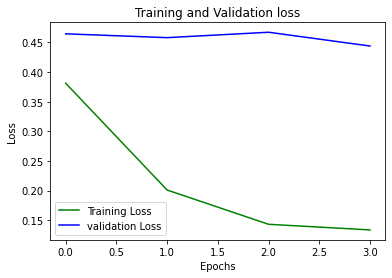

In [54]:
plot_loss('loss','val_loss')

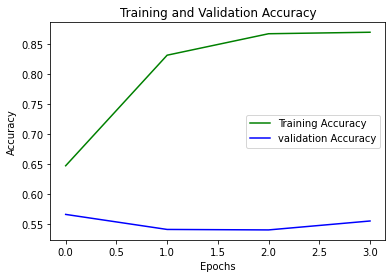

In [55]:
plot_accuracy('acc','val_acc')

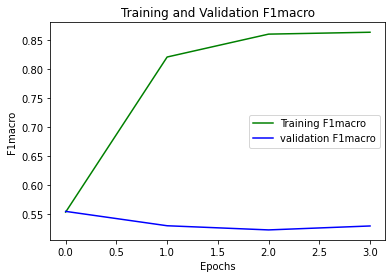

In [56]:
plot_f1macro('f1macro','val_f1macro')

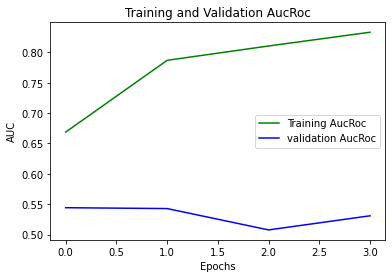

In [57]:
plot_Aucroc('auc','val_auc')

## For 20 Days

In [58]:
# For 20 Days
seq_len = 20
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'DJI'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'DJI'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'DJI')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 20, 1, 8)          664       
                                                                 
 conv2d_31 (Conv2D)          (None, 18, 1, 8)          200       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 9, 1, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 7, 1, 8)           200       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 3, 1, 8)          0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 24)              

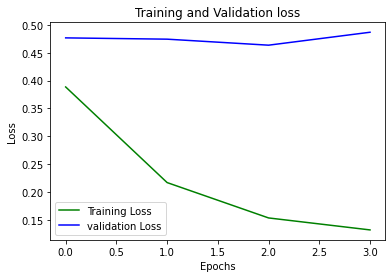

In [59]:
plot_loss('loss','val_loss')

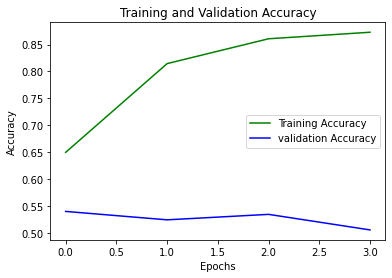

In [60]:
plot_accuracy('acc','val_acc')

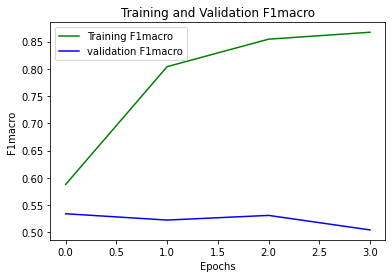

In [61]:
plot_f1macro('f1macro','val_f1macro')

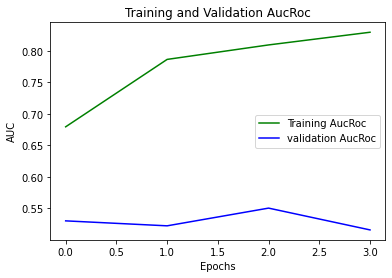

In [62]:
plot_Aucroc('auc','val_auc')

## For 10 Days

In [63]:
# For 10 Days
seq_len = 10
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'DJI'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'DJI'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'DJI')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 10, 1, 8)          664       
                                                                 
 conv2d_34 (Conv2D)          (None, 8, 1, 8)           200       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 4, 1, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 2, 1, 8)           200       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 1, 1, 8)          0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 8)               

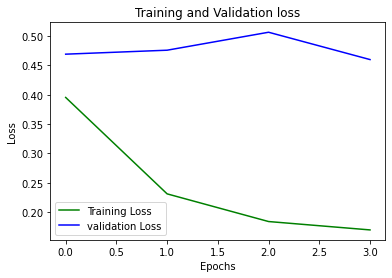

In [64]:
plot_loss('loss','val_loss')

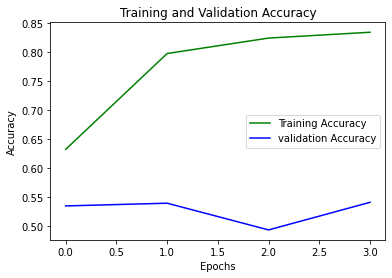

In [65]:
plot_accuracy('acc','val_acc')

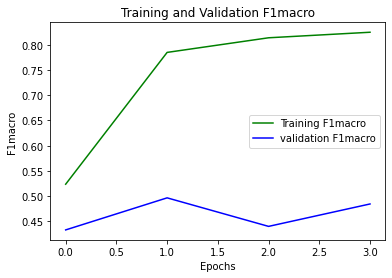

In [66]:
plot_f1macro('f1macro','val_f1macro')

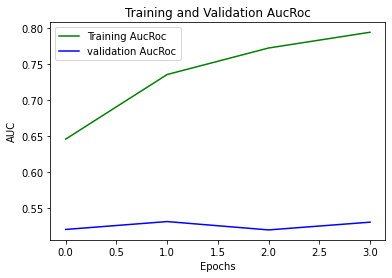

In [67]:
plot_Aucroc('auc','val_auc')

# For RUT

## For 60 Days

In [68]:
# For 60 Days
seq_len = 60
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'RUT'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'RUT'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'RUT')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 60, 1, 8)          664       
                                                                 
 conv2d_37 (Conv2D)          (None, 58, 1, 8)          200       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 29, 1, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 27, 1, 8)          200       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 13, 1, 8)         0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 104)             

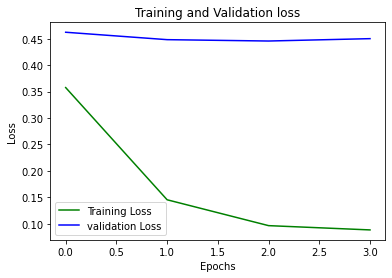

In [69]:
plot_loss('loss','val_loss')

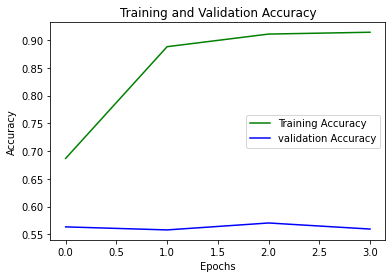

In [70]:
plot_accuracy('acc','val_acc')

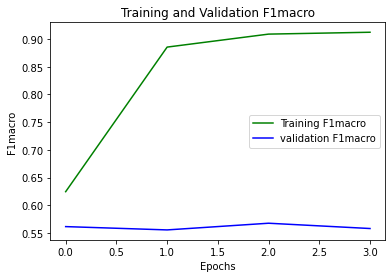

In [71]:
plot_f1macro('f1macro','val_f1macro')

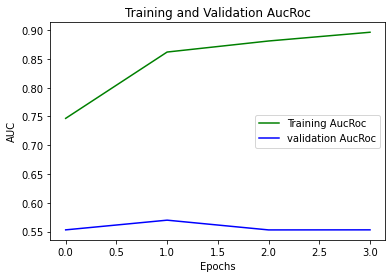

In [72]:
plot_Aucroc('auc','val_auc')

## For 30 Days

In [73]:
# For 30 Days
seq_len = 30
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'RUT'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'RUT'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'RUT')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 30, 1, 8)          664       
                                                                 
 conv2d_40 (Conv2D)          (None, 28, 1, 8)          200       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 14, 1, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 12, 1, 8)          200       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 6, 1, 8)          0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 48)              

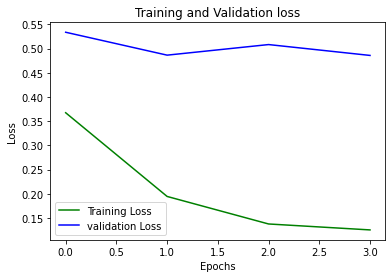

In [74]:
plot_loss('loss','val_loss')

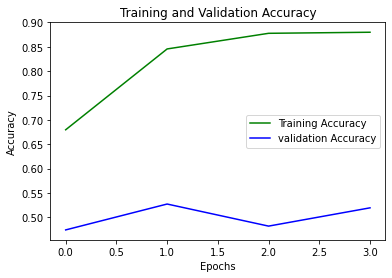

In [75]:
plot_accuracy('acc','val_acc')

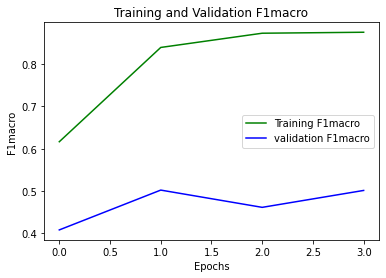

In [76]:
plot_f1macro('f1macro','val_f1macro')

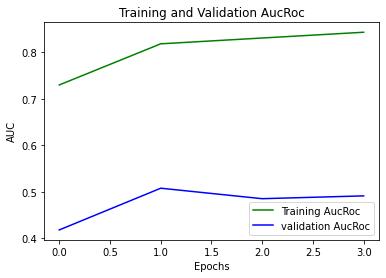

In [77]:
plot_Aucroc('auc','val_auc')

## For 20 Days 

In [78]:
# For 20 Days
seq_len = 20
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'RUT'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'RUT'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'RUT')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 20, 1, 8)          664       
                                                                 
 conv2d_43 (Conv2D)          (None, 18, 1, 8)          200       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 9, 1, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 7, 1, 8)           200       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 3, 1, 8)          0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 24)              

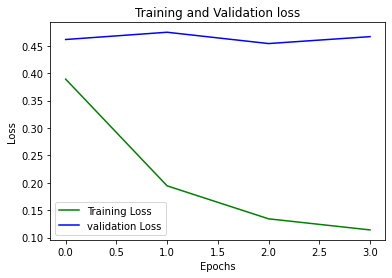

In [79]:
plot_loss('loss','val_loss')

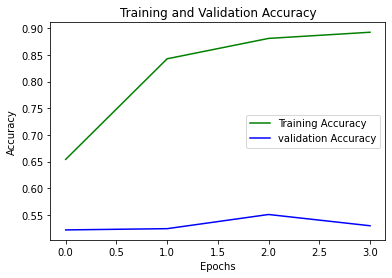

In [80]:
plot_accuracy('acc','val_acc')

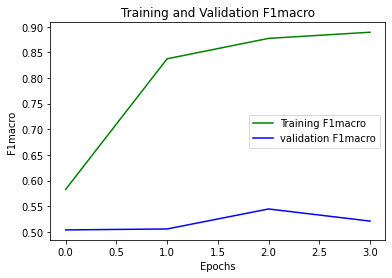

In [81]:
plot_f1macro('f1macro','val_f1macro')

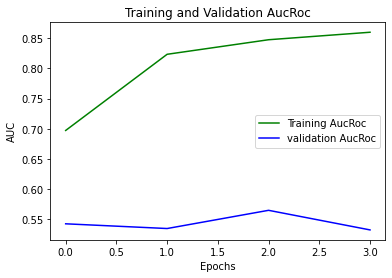

In [82]:
plot_Aucroc('auc','val_auc')

## For 10 Days

In [83]:
# For 10 Days
seq_len = 10
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'RUT'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'RUT'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'RUT')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 10, 1, 8)          664       
                                                                 
 conv2d_46 (Conv2D)          (None, 8, 1, 8)           200       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 4, 1, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 2, 1, 8)           200       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 1, 1, 8)          0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 8)               

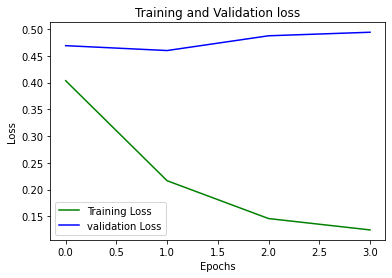

In [84]:
plot_loss('loss','val_loss')

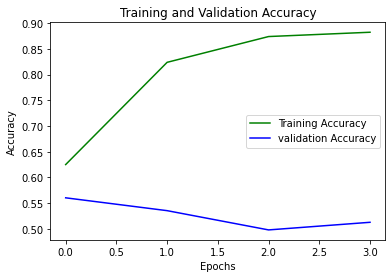

In [85]:
plot_accuracy('acc','val_acc')

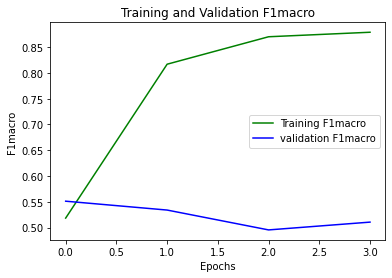

In [86]:
plot_f1macro('f1macro','val_f1macro')

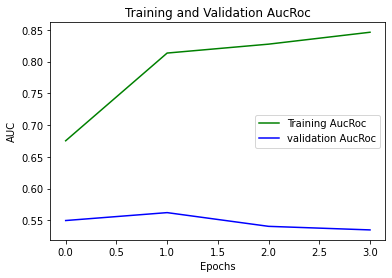

In [87]:
plot_Aucroc('auc','val_auc')

# For NASDAQ

## For 60 Days

In [88]:
# For 60 Days
seq_len = 60
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'NASDAQ'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'NASDAQ'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'NASDAQ')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 60, 1, 8)          664       
                                                                 
 conv2d_49 (Conv2D)          (None, 58, 1, 8)          200       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 29, 1, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 27, 1, 8)          200       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 13, 1, 8)         0         
 g2D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 104)             

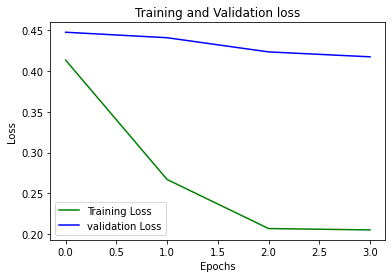

In [89]:
plot_loss('loss','val_loss')

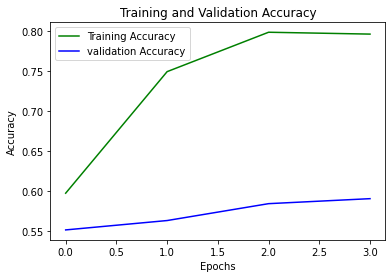

In [90]:
plot_accuracy('acc','val_acc')

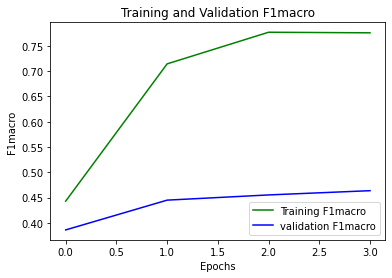

In [91]:
plot_f1macro('f1macro','val_f1macro')

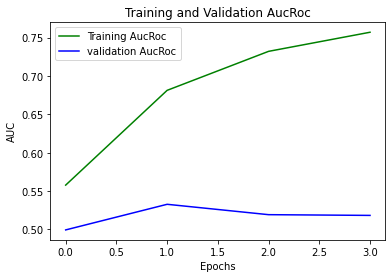

In [92]:
plot_Aucroc('auc','val_auc')

## For 30 Days

In [93]:
# For 30 Days
seq_len = 30
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'NASDAQ'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'NASDAQ'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'NASDAQ')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 30, 1, 8)          664       
                                                                 
 conv2d_52 (Conv2D)          (None, 28, 1, 8)          200       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 14, 1, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 12, 1, 8)          200       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 6, 1, 8)          0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 48)              

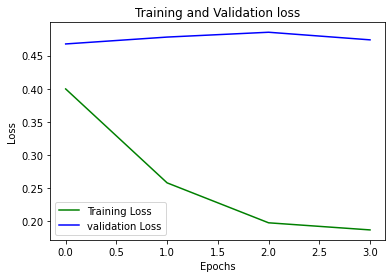

In [94]:
plot_loss('loss','val_loss')

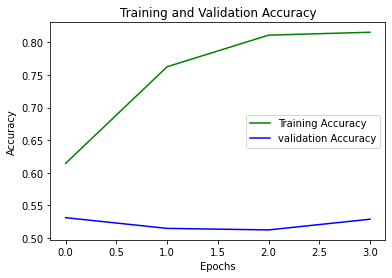

In [95]:
plot_accuracy('acc','val_acc')

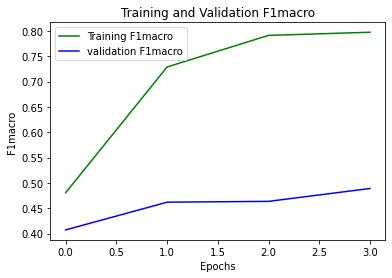

In [96]:
plot_f1macro('f1macro','val_f1macro')

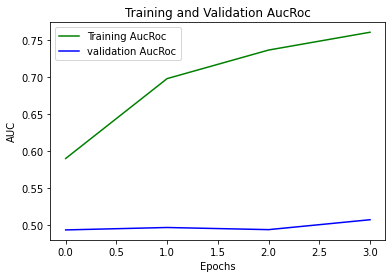

In [97]:
plot_Aucroc('auc','val_auc')

## For 20 Days

In [98]:
# For 20 Days
seq_len = 20
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'NASDAQ'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'NASDAQ'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'NASDAQ')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 20, 1, 8)          664       
                                                                 
 conv2d_55 (Conv2D)          (None, 18, 1, 8)          200       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 9, 1, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 7, 1, 8)           200       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 3, 1, 8)          0         
 g2D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 24)              

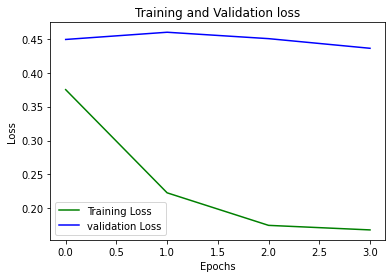

In [99]:
plot_loss('loss','val_loss')

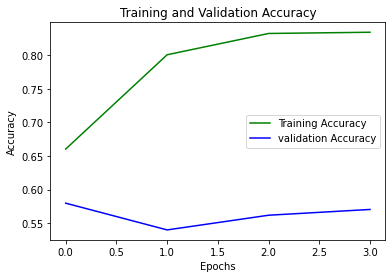

In [100]:
plot_accuracy('acc','val_acc')

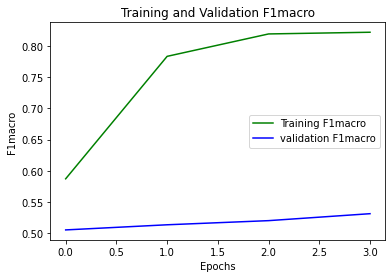

In [101]:
plot_f1macro('f1macro','val_f1macro')

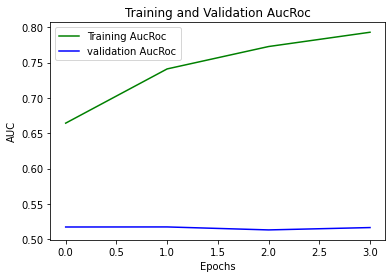

In [102]:
plot_Aucroc('auc','val_auc')

## For 10 Days

In [103]:
# For 10 Days
seq_len = 10
batch_size = 128
n_epochs = 4
n_features = 82

# Produce CNNpred as a binary classification problem
model = cnnpred_2d(seq_len, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
history = model.fit(datagen(data, seq_len, batch_size, "Target", "train",'NASDAQ'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'NASDAQ'),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'NASDAQ')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy: ", accuracy_score(test_pred, test_target))
print("MAE: ", mean_absolute_error(test_pred, test_target))
print("F1: ", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 10, 1, 8)          664       
                                                                 
 conv2d_58 (Conv2D)          (None, 8, 1, 8)           200       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 4, 1, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 2, 1, 8)           200       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 1, 1, 8)          0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 8)               

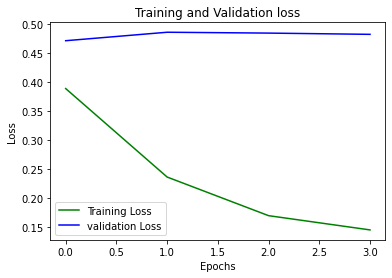

In [104]:
plot_loss('loss','val_loss')

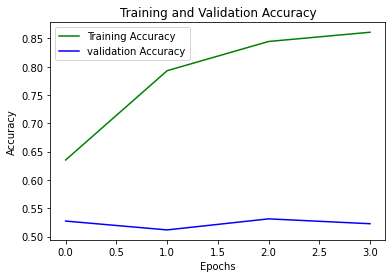

In [105]:
plot_accuracy('acc','val_acc')

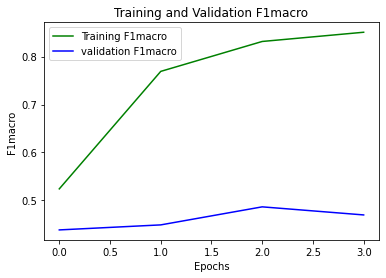

In [106]:
plot_f1macro('f1macro','val_f1macro')

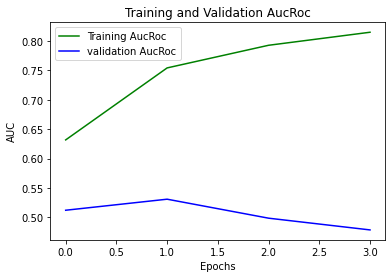

In [107]:
plot_Aucroc('auc','val_auc')